# A COMPLETE INTRODUCTION TO GRAPH NEURAL NETWORKS USING PYTORCH

# 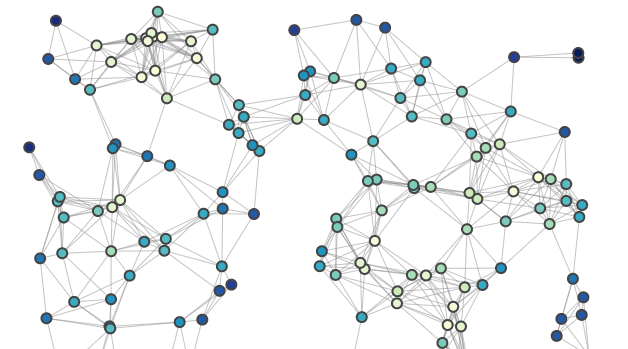


In this notebook, we will demonstrate the big potential of Graph Neural Networks (GNN) using **PyTorch Geometric**.

We will try to **classify the** <code>cora</code> **dataset**, a citation network where the nodes are documents, the features are their world embeddings, the label is the document type, and the edges are the link citations among documents.

Throughout the notebook we will follow these steps:

1. **Dealing with graph data**: in this part, we want to understand *how to deal with <code>Data</code> and <code>Dataset</code> modules*.
    
    They will be very useful to understand how to manage graph data in real business cases. In addition, we will *split the data in training set, validation set and, test set in a graph context* where this splitting is not trivial.

2. **Modelling a graph**: in this part we want to create a *simple GNN architecture* to understand Pytorch Geometric and how to train our network.

    After that, we want to compare it with some other approaches such as label propagation and random forest. 

    In particular:

    - *GNN*: works both on the topology of the graph and nodes features. We will add some graph global features such as page rank, community, etc.

    - *label propagation algorithm*: works only on topology.

    - *random forest*: works only on features.

3. **Tuning a GNN and batching a graph**: in this part, we will deal with more advanced concepts.

    In particular, we will tune a *complex GNN architecture* and try *mini-batch approaches* to our problem to increase speed in computation.

# IMPORTING THE LIBRARIES

We first need to import all the important dependencies for the notebook.

In [1]:
import torch   
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU, Dropout

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn.norm import BatchNorm
from torch_geometric import seed_everything
from torch_geometric.nn import GCNConv, GATv2Conv, GINConv, SAGEConv
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.loader import NeighborSampler
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid

import networkx as nx   

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

import os
from tqdm import tqdm
import time

C:\Users\j.genovese\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's take the dataset path we will use throughout the notebook.

In [2]:
path_dataset = os.path.join(os.getcwd(), r"datasets/")

Set a different device according to what you have. In my case I will use a CPU, but you can also have a GPU.

In [3]:
device = 'cpu'
if torch.cuda.is_available():
    print('A Gpu is available')
    device = torch.device("cuda:0")  
    !nvidia-smi
else:
    print("Only the CPU is available")
    device = torch.device("cpu") 

Only the CPU is available


In [4]:
device

device(type='cpu')

Now download the dataset. In the root we put the subfolder where the dataset will be downloaded.

In [5]:
if not os.path.isdir(os.path.join(path_dataset, "Cora")):
    dataset = Planetoid(root="datasets", name="Cora", split="full")
else:
    dataset = torch.load(os.path.join(os.getcwd(), r"datasets/Cora/processed/data.pt"))

Processing...
Done!


Let's set the seed to repeat the experiments. 

In [6]:
seed_everything(105)

# 1. DEALING WITH GRAPH DATA

## 1.1 INTRODUCTION TO THE DATA CLASS

In this part, we want to analyze this dataset and better understand the <code>Data</code> class.

Let's start seeing the dataset type.

In [7]:
type(dataset)

torch_geometric.datasets.planetoid.Planetoid

It's a Planetoid type that inherits from the <code>datasets</code> class, which we will see later.

In general we could have more <code>Data</code> objects in a <code>Dataset</code> object, representing each one a single graph. In this case we have only one and we extract it.

In [8]:
data_preproc = dataset[0].to(device)

Let's see the <code>Data</code> object.

In [9]:
data_preproc

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In **PyTorch Geometric** a <code>Data</code> object is an object where we usually store:

- <code>x</code>: the nodes and their feautures. In this case we have 2708 nodes and 1433 features associated to it.

- <code>edge_index</code>: this field of dimensionality <code>[2, num_edges]</code> is the links representation in the graph.

- <code>y</code>: the node labels 

Having set these fields, we can use the methods of this class to obtain PyTorch tensor functionalities.

We just want to add that we can also have other fields like, in this case, <code>train mask</code>, <code>val_mask</code> and <code>test_mask</code>.

We will not use them because we will do our split.

**Let's see some graph features that we can extract from the object methods.**

In [10]:
print(f'Number of nodes: {data_preproc.num_nodes}')
print(f'Number of edges: {data_preproc.num_edges}')
print(f'Number of classes: {len(np.unique(data_preproc.y))}')

print(f'Number of features per nodes: {data_preproc.num_node_features}')
print(f'Average node degree: {(2*data_preproc.num_edges) / data_preproc.num_nodes:.2f}')
print(f'Is undirected: {data_preproc.is_undirected()}')
print("\n")

Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Number of features per nodes: 1433
Average node degree: 7.80
Is undirected: True




We have a bunch of other methods that we can use thanks to the data class.

Let's now see the class distribution.

Text(0.5, 1.0, 'Classes distribution')

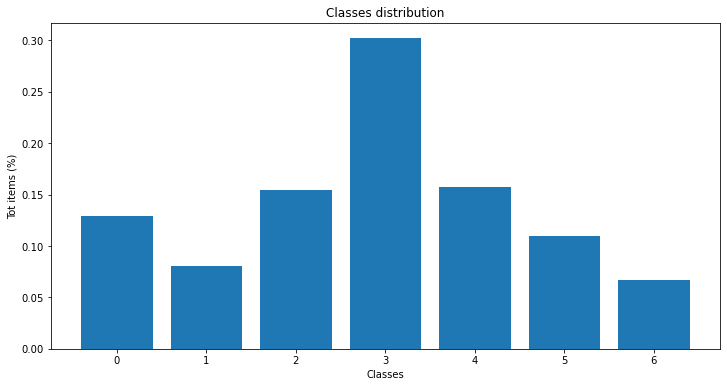

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

normalized_items = [(i, data_preproc.y.tolist().count(i) / data_preproc.num_nodes) for i in np.unique(data_preproc.y)]
classes = [i[0] for i in normalized_items]
normalized_number = [i[1] for i in normalized_items]

ax.bar(classes, normalized_number)
ax.set_xlabel('Classes')
ax.set_ylabel('Tot items (%)')
ax.set_title("Classes distribution")

We are dealing with a pretty balanced dataset. We don't need to balance the dataset in the classification.

We conclude by saying that the <code>data</code> class, rather than the <code>datasets</code>, can be used for:

- analysis, where the **data are already clean and usable** for our algorithms.

- analysis, where we **don't want to store the data to disk** but do an analysis on the fly. 

The cases in which we need to store and preprocess our data need the <code>datasets</code> class.

## 1.2. INTRODUCTION TO THE DATASET CLASS

In this part, we want to explain how to deal with general use cases where the <code>Dataset</code> is needed.

For doing it we will first create some CSV from the previous dataset. We want to put the nodes and their relative features and labels in a file and the edges in another one.

In that way, it looks like a real use case.

### 1.2.1 CREATE A FAKE CSV FILE

First of all we need to create a folder with the raw files. 

In [12]:
# Check whether the specified path exists or not
raw_folder = os.path.join(path_dataset, "raw")
isExist = os.path.exists(raw_folder)

if not isExist:  
    os.makedirs(os.path.join(path_dataset, "raw"))

Now we need to create the csv files. For doing it we will convert our tensor in pandas dataframes.

In [13]:
features = pd.DataFrame(data_preproc.x.numpy())
label = pd.DataFrame(data_preproc.y.numpy(), columns = ["label"])
df_nodes = label.merge(features, left_index=True, right_index=True)

In [14]:
df_nodes.to_csv(os.path.join(raw_folder, "nodes.csv"),sep =";", index = False)

Let's pass to the edge tensor.

In [15]:
pd.DataFrame(data_preproc.edge_index.t().numpy()).to_csv(os.path.join(raw_folder, "edges.csv"),sep =";", index = False)

Now we have our CSV files and we can create a class to load and process them.

### 1.2.2 READ AND PROCESS THE CSV FILES

In this part, we want to read and process the CSV files like in real use cases. 

For doing it, a good solution can be to extend the two datasets class **InMemoryDataset** or **Dataset**.

We can use:

- <code>InMemoryDataset</code> when we have a graph that fit in CPU memory.

- <code>Dataset</code> when we have big graphs that don't fit in CPU memory.

In our case, we will use an InMemoryDataset.

This class usually requires to implement these methods:

- <code>download</code>: this method downloads the data from the web into the *raw* folder.
  
- <code>raw_file_names</code>: this method returns the raw file names that we want in the *raw* folder. If they are not present it triggers the download method.

- <code>process</code>: here we process the data in the *raw* folder and put the results in the *processed* folder.
    In our process we want to read the csv files and create the <code>Data</code> object.

    After that we want **split it into training, validation, and test set** (70/15/15) and save it in the *processed folder*.

- <code>processed_file_names</code>: this method returns the processed file names in the *processed* folder. If they are not present it triggers the process method.



All these methods are triggered by the parent class constructor that we see in <code>super().__init__(root)</code>.

After that we want our costructor load the entire dataset. 

In [22]:
class MyDataset(InMemoryDataset):
    def __init__(self, root):
        """
        We have a raw folder with all the files related to the graph and a processed one with the final ones that will be used later.
        """
        super().__init__(root)
        self.dataset_splitted =  torch.load(os.path.join(self.processed_dir, self.processed_file_names[0]))

    @property
    def raw_file_names(self):
        """
        If these files are present we will to trigger the download function.
        """
        return ['edges.csv', 'nodes.csv']
    
    @property
    def processed_file_names(self):
        """
        If these files are present we will not trigger the process function.
        """
        return ['dataset_splitted.pt']

    def process(self):
        """
        The core part that transform raw into clean code 
        """        
        for file in self.raw_paths:
            if "nodes" in file:
                df_nodes = pd.read_csv(file, sep = ";")
            else:
                df_edges = pd.read_csv(file,sep=";")
        # here we create our starting dataser        
        new_dataset = Data()

        new_dataset.y = torch.tensor(df_nodes['label'].values)
        new_dataset.x = torch.tensor(df_nodes.drop("label", axis = 1).values)    
        new_dataset.edge_index = torch.tensor(df_edges.values).t()
    
        transform = RandomNodeSplit(num_val=0.15, num_test=0.15)
        
        dataset_splitted = transform(new_dataset)
        torch.save(dataset_splitted, os.path.join(self.processed_dir, 'dataset_splitted.pt'))

Let's start the process.

In [17]:
md = MyDataset(os.path.join(os.getcwd(), r"datasets/"))

Processing...
Done!


In [19]:
dataset_final = md.dataset_splitted

Let's see the final dataset.

In [20]:
dataset_final

Data(y=[2708], x=[2708, 1433], edge_index=[2, 10556], train_mask=[2708], val_mask=[2708], test_mask=[2708])

We see the nodes and their labels, the edges, and the different masks.

Let's see the proportion splitting.

In [21]:
print(dataset_final.train_mask.sum() / dataset_final.x.shape[0])
print(dataset_final.val_mask.sum() / dataset_final.x.shape[0])
print(dataset_final.test_mask.sum() / dataset_final.x.shape[0])

tensor(0.7001)
tensor(0.1499)
tensor(0.1499)


As expected.

In this last part we want to explain the two functions available in the <code>transform</code> module that we can use for the splitting:

- <code>RandomNodeSplit</code>: in this case boolean masks for nodes are created at random where the *true* value says that this node is used for training/validation/test set. 

    *Pay attention*: we are in a **transductive setting**. In fact, we will give all the nodes for the message passing in the training phase but the loss will be evaluated only for the training nodes.

- <code>RandomLinkSplit</code>: the edge splitting is far more complicated and we don't go into details. We only note that there is only an edge splitting, not related to node splitting. We can't use for node classification.

In general, splitting nodes is not trivial because they are not independent since they are interconnected.

If you are interested in more details on the splitting technique a very good source is [here](https://www.youtube.com/watch?v=ewEW_EMzRuo&ab_channel=StanfordOnline).

---------

# 2. MODELING A GRAPH

In this part we want to create a simple graph neural network, to understand how it works and how it performs with respect to other methods.

We will:

- start **creating a simple GCN layer** and understand how to train it and test the performance.

- **compare it with some simpler methods** like label propagation and random forests.

- **add some global graph features** like page rank, betweeness centrality, louvain community, etc. and see if the performance changes. The reason for that step is that GNN only learn local features but sometimes it can be useful to know something global as well.

## 2.1 CREATION OF A ONE-LAYER GCN

Let's create an easy Graph Convolutional Network with only one layer.

We want to remind that the layer equation is:
$$
\mathbf{x}^{\prime}_i = \sigma\big(\mathbf{\Theta}^{\top} \sum_{j \in
        \mathcal{N}(v) \cup \{ i \}} \frac{1}{\sqrt{\hat{d}_j
        \hat{d}_i}} \mathbf{x}_j\big)
$$

The idea is to pass messages from node neighbors, aggregate and normalize them, apply a linear transformation followed by a non-linearity (usually a ReLu) and upgrade the node status.

In our one-layer GCN, used to a multiclass classification, the result of the aggregation is passed to a *log-softmax*.

This choice of the log is related with the fact that is more numerically stable with low probabilities.

**To implement an architecture in PyTorch Geometric** we need:

- to create a **class** that inherits from the <code>torch.nn.module</code>. With this inheritance we have access to all the class methods, related for example with the training phase.

- in the <code>\_\_init\_\_</code> we define the layer we want to train and learn the parameters. In fact the <code>torch.nn.Module</code> will register the parameters and update them

- in the <code>forward</code> we define how these layer interacts. In this case we have created the previous architecture but in addition we return the embedding before the log softmax to plot it later.


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, output_classes, return_embedding=False):
        super(GCN, self).__init__()
        
        self.conv1 = GCNConv(in_channels = in_dim, 
                             out_channels = output_classes,
                             add_self_loops = True)
        self.return_embedding = return_embedding
        
    def reset_parameters(self): # this method is useful to retrain the network
        self.conv1.reset_parameters()
        
    def forward(self, data_input):
        x, edge_index = data_input.x.float(), data_input.edge_index
        x = self.conv1(x, edge_index)
        embedding = F.relu(x)
        if self.return_embedding:
            # dim = 1 means that we fix the row and sum over the column.
            return F.log_softmax(embedding, dim=1), embedding
        else:
            return F.log_softmax(embedding, dim=1)

Let's create the model. 

We note that when we call the model in such a way <code>model(.,.)</code> we are calling the <code>\_\_call\_\_</code> method that calls the <code>forward</code> method.

In [ ]:
in_dim = dataset_final.num_features
n_classes = len(np.unique(dataset_final.y))
model_GCN_1_layer = GCN(in_dim=in_dim, output_classes = n_classes, return_embedding=True).to(device)

Let's train our model. We will **create a general function** that works regardless of the given model and the data set.

To do it we will follow these steps:

1. call an Adam optimizer. We could take the optimizier as a parameter but in this case we are not interested in fine-tuning the network.

2. create an <code>history</code> dictionary where we store loss and accuracy metrics.

3. call the <code>model.train()</code>: this tells your model that you are training the model, so the layers like dropout are enabled. In this case we are not using them, but in the future it will be useful. 


4. call <code>loss.backward()</code>. All it does is computing the loss gradient w.r.t all the parameters that have requires_grad = True and store them in parameter.grad attribute for every parameter.

5. call <code>optimizer.step()</code> updates all the parameters based on parameter.grad.

6. call <code>optimizer.zero_grad()</code>: cancel all the gradients stored in the optimizier.

7. test the performance calling <code>with torch.no_grad()</code> that disables the computational graph. We will use the <code>model.eval()</code> that will disable the training layers. We also have implemented an early stopping to avoid to train for too long.


In [ ]:
def train_model(model, data_total, verbose=True):
    start_time_sec = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    history = {}
    history['loss_train'] = []
    history['loss_val'] = []
    history['acc_train'] = []
    history['acc_val'] = []
    history['epoch'] = []

    patience = 20
    last_val_acc = 0
    model.reset_parameters()


    for epoch in range(1000):

        history['epoch'].append(epoch)
        model.train()

        # zero_grad delete from memory the previous gradients.
        optimizer.zero_grad()
        pred, embedding = model(data_total)
        loss_train = F.nll_loss(pred[data_total.train_mask], data_total.y[data_total.train_mask])
        
        # backward create the gradients
        loss_train.backward()
        # step update the weights using the gradient
        optimizer.step()  

        model.eval()

        with torch.no_grad():
            pred, emb = model(data_total)
            pred_max = pred.argmax(dim=1)
            # computing accuracy on training
            correct_train = (pred_max[data_total.train_mask] == data_total.y[data_total.train_mask]).sum()
            n_sample_acc =  int(data_total.x[data_total.train_mask].shape[0])
            acc_train = int(correct_train) / n_sample_acc

            # computing accuracy on validation
            correct_val = (pred_max[data_total.val_mask] == data_total.y[data_total.val_mask]).sum()
            n_sample_val =  int(data_total.x[data_total.val_mask].shape[0])
            acc_val = int(correct_val) / n_sample_val
            # computing loss on validation
            loss_val = F.nll_loss(pred[data_total.val_mask], data_total.y[data_total.val_mask])
            # item is used to extract the number from the tensor
            history['loss_train'].append(loss_train.item())
            history['loss_val'].append(loss_val.item())
            history['acc_train'].append(acc_train)
            history['acc_val'].append(acc_val)
            if epoch % 100 == 0 and verbose:
                print(f"Epoch: {epoch}, acc train: {acc_train}, acc val: {acc_val}")
            # early stopping 
            if history['acc_val'][-1] < last_val_acc:
                trigger_times += 1
                if trigger_times >= patience:
                    if verbose:
                        print(f'Early stopping: stop training. Epoch: {epoch}')
                    break
            else:
                trigger_times = 0
                last_val_acc =  history['acc_val'][-1]
    model_weights = model.state_dict()
    
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    if verbose:
        print(f"Epoch: {epoch}, acc train: {acc_train}, acc val: {acc_val}")
        print('Time total:     %5.2f sec' % (total_time_sec))
    return history, emb, model_weights

In [ ]:
history, embedding, _ = train_model(model_GCN_1_layer, data_total=dataset_final)

As we can see the training is very fast.

Let's see both train and validation loss.

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history['epoch'], history['loss_train'], label='train', color = "blue")
ax.plot(history['epoch'], history['loss_val'], label='validation', color = "red")

ax.set_title('Training and validation loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper left')
plt.show()

Let's see both training and validation accuracy.

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history['epoch'], history['acc_train'], label='train', color = "blue")
ax.plot(history['epoch'], history['acc_val'], label='validation', color = "red")

ax.set_title('Training and validation accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(loc='upper left')
plt.show()

It's quite clear that the results are quite good despite of a little bit of overfitting.

We want to implement a method to see if the results are stable on the test set as well.

In [ ]:
def test_model(model, data_total):
    model.eval()
    pred, emb = model(data_total)
    test_pred = pred.argmax(dim=1)
    correct = (test_pred[data_total.test_mask] == data_total.y[data_total.test_mask]).sum()
    acc = int(correct) / int(data_total.x[data_total.test_mask].shape[0])
    print(f'Test Accuracy: {acc:.4f}')

In [ ]:
test_model(model_GCN_1_layer, data_total=dataset_final)

As we can see they are stable so our network is quite good!

Now we want to see if the embedding is good to split our points.

In this case we plot our embedding using a T-SNE to reduce the dimensionality. We also add a color related to the class.

In [ ]:
def plot_embedding2D(h, color, size=100, title=""):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False, init="pca", learning_rate=200).fit_transform(h)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.set_cmap("tab10")
    ax.set_title(title)
    ax.scatter(h[:, 0], h[:, 1], c=color, s=size)
    ax.legend()
    plt.show()

In [ ]:
plot_embedding2D(h = embedding, color = dataset_final.y)

We can see that sometimes there is some overlapping but we already have a good splitting as the results said.

In [ ]:
sys.exit()

## 2.2 TESTING WITH CLASSICAL MACHINE LEARNING

In this part we want **to compare the results of the GCN with a traditional random forest applied to the feature data and with a label propagation algorithm applied to the topology.**

Let's start with the random forest.

In [ ]:
X_train = pd.DataFrame(dataset_final.x[dataset_final.train_mask].detach().numpy())
X_test = pd.DataFrame(dataset_final.x[dataset_final.test_mask].detach().numpy())
print(f'X_train\tshape: {X_train.shape}\nX_test\tshape: {X_test.shape}')

y_train = dataset_final.y[dataset_final.train_mask].detach().numpy().reshape(-1,)
y_test = dataset_final.y[dataset_final.test_mask].detach().numpy().reshape(-1,)
print(f'y_train\tshape: {y_train.shape}\ny_test\tshape: {y_test.shape}')

In [ ]:
clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators= 500)
clf.fit(X_train, y_train)

In [ ]:
y_predict_train = clf.predict(X_train)
correct = (y_predict_train == y_train).sum()
acc = int(correct) / int(y_train.shape[0])
print(f'Accuracy train: {acc:.4f}')

In [ ]:
y_predict = clf.predict(X_test)
correct = (y_predict == y_test).sum()
acc = int(correct) / int(y_test.shape[0])
print(f'Accuracy test: {acc:.4f}')

As you can see we are not overfitting the train set but the results are not good as before.

The features don't have all the information we need to classify the nodes.

Let's move on to the **label propagation algorithm**.

We have to implement from scratch because we didn't find a right version for us.

We take ispiration from [here](https://towardsdatascience.com/label-propagation-demystified-cd5390f27472).

Our idea is to use the communities that we have in the train set to spread the label and infer the validation and test set.

In [ ]:
G = to_networkx(dataset_final, to_undirected=True)

We first create the transition matrix.

In [ ]:
A = nx.adjacency_matrix(G) 
D = np.sum(A,1)
D = np.diag(np.array(D)[:,0])
Dinv = np.linalg.inv(D)

T = Dinv * A

After that we create the initial label vector.

In [ ]:
# Create an array of zeros with size (number of nodes, number of classes)
Y = np.zeros((dataset_final.num_nodes, n_classes)) 
train_mask = dataset_final.train_mask + dataset_final.val_mask        # Consider for the train both train and validation nodes
Y[train_mask, dataset_final.y[train_mask]] = 1               # Assign 1 in the index position of that class for nodes in the training set (a node with class 2 will have a mask like [0, 0, 1, ...])
Y = np.matrix(Y)

In [ ]:
def LabelPropagation(T, Y, diff, max_iter, labelled):
    import sys
    # Initialize
    Y_init = Y
    Y1 = Y
    
    # Initialize convergence parameters
    n=0
    current_diff = sys.maxsize
    
    # Iterate till difference reduces below diff or till the maximum number of iterations is reached
    while current_diff > diff and n < max_iter:
        
        current_diff = 0.0
        # Set Y(t)
        Y0 = Y1
        
        # Calculate Y(t+1)
        Y1 = T*Y0
        
        # Clamp labelled data
        for i in range(Y_init.shape[0]):
            if i in labelled:
                for j in range(Y_init.shape[1]):
                    if i!=j:
                        Y1.A[i][j] = Y_init.A[i][j]
        
        # Get difference between values of Y(t+1) and Y(t)
        for i in range(Y1.shape[0]):
            for j in range(Y1.shape[1]):
                current_diff += abs(Y1.A[i][j] - Y0.A[i][j])
        
        n += 1
        
    return Y1

In [ ]:
true_values = dataset_final.train_mask.nonzero().reshape(-1).tolist()

In [ ]:
%%time
L = LabelPropagation(T, Y, 0.0001, 100, true_values)

In [ ]:
y_pred = np.asarray(L.argmax(1)).reshape(-1,)[dataset_final.test_mask]
print(f'Accuracy on test: {accuracy_score(y_test, y_pred)*100:.2f}%')

As we can see we reach good results using only the graph topology.

## 2.3 ADD GRAPH FEATURES

In this part we want to add some global features. Maybe they can be useful to better predict the results.

We will introduce:

- page rank centrality
- closeness centrality
- degree centrality 
- betweeness centrality
- number of triangles
- clustering coefficient

In [ ]:
G = to_networkx(dataset_final, to_undirected=True)

In [ ]:
pr = torch.Tensor(list(nx.pagerank(G, alpha=0.8).values()))
cc = torch.Tensor(list(nx.closeness_centrality(G).values()))
dc = torch.Tensor(list(nx.degree_centrality(G).values()))
bc = torch.Tensor(list(nx.betweenness_centrality(G).values()))
ntr = torch.Tensor(list(nx.triangles(G).values()))
ccf = torch.Tensor(list(nx.clustering(G).values()))

Let's create the dataset with the added features.

For doing it we have to create a new dataset with the cloned data.

In [ ]:
data_aug_feature = Data()
data_aug_feature.x = torch.clone(dataset_final.x)
data_aug_feature.y = torch.clone(dataset_final.y)
data_aug_feature.edge_index = torch.clone(dataset_final.edge_index)
data_aug_feature.train_mask = torch.clone(dataset_final.train_mask)
data_aug_feature.val_mask = torch.clone(dataset_final.val_mask)
data_aug_feature.test_mask = torch.clone(dataset_final.test_mask)

In [ ]:
data_aug_feature.x = torch.column_stack((data_aug_feature.x, pr, cc, dc, bc, ntr, ccf))

Let's create the new model and train the model.

In [ ]:
in_dim = data_aug_feature.num_features
n_classes = len(np.unique(data_aug_feature.y))
model_GCN_1_layer_aug_feature = GCN(in_dim=in_dim, output_classes = n_classes, return_embedding=True).to(device)

In [ ]:
history_aug_features, _, _ = train_model(model_GCN_1_layer_aug_feature, data_total=data_aug_feature)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history_aug_features['epoch'], history_aug_features['acc_train'], label='train', color = "blue")
ax.plot(history_aug_features['epoch'], history_aug_features['acc_val'], label='validation', color = "red")

ax.set_title('Training and validation accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(loc='upper left')
plt.show()

In [ ]:
test_model(model_GCN_1_layer_aug_feature, data_total=data_aug_feature)

We see a little improvement but it's not clear if this is related with a real one or this just by chance.

In [ ]:
sys.exit()

# 3. TUNING A GNN AND BATCHING A GRAPH

In this chapter we want to introduce more complex architecture and methodologies to deal with graphs.

- In the first part we will try to use new convolutional layers and compare the results.

- In the second part we will create more complex architectures to improve the model understanding how to tune a model

- In the third part we will create a data sampler to batch the data in the graph

## 3.1 CHANGING THE CONVOLUTIONAL LAYERS

In this part we want to show how to change the convolutional layers.

In particular we will try a GAT layer that gives some weights on the input and a GIN layer that try to improve the graph convolution.

In [ ]:
class GAT_1layer(torch.nn.Module):
    def __init__(self, in_dim, output_classes, heads, concat, return_embedding=False):
        super(GAT_1layer, self).__init__()
        
        self.conv1 = GATv2Conv(in_channels = in_dim, 
                             out_channels = output_classes,
                             add_self_loops = True,
                             heads =heads,
                             concat=concat)
        self.return_embedding = return_embedding
        
    def reset_parameters(self): # this method is useful to retrain the network
        self.conv1.reset_parameters()
        
    def forward(self, data_input):
        x, edge_index = data_input.x.float(), data_input.edge_index
        x = self.conv1(x, edge_index)
        embedding = F.relu(x)
        if self.return_embedding:
            # dim = 1 means that we fix the row and sum over the column.
            return F.log_softmax(embedding, dim=1), embedding
        else:
            return F.log_softmax(embedding, dim=1)

In [ ]:
in_dim = dataset_final.num_features
n_classes = len(np.unique(dataset_final.y))
model_GAT_1layer = GAT_1layer(in_dim=in_dim, output_classes = n_classes,heads=3, concat=False, return_embedding=True).to(device)

In [ ]:
history_GAT1layer, embedding_GAT1layer, _ = train_model(model = model_GAT_1layer, data_total=dataset_final)

In [ ]:
test_model(model_GAT_1layer, data_total=dataset_final)

In this case we can see that we don't have an improvement.

In [ ]:
class GIN_1layer(torch.nn.Module):
    def __init__(self, in_dim, output_classes, return_embedding=False):
        super(GIN_1layer, self).__init__()
        dim = 16
        self.conv1 =  GINConv(
                       Sequential(Linear(in_dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, output_classes), ReLU())
        ) # GINConv takes a neural network as input
        self.return_embedding = return_embedding
        
    def reset_parameters(self): # this method is useful to retrain the network
        self.conv1.reset_parameters()
        
    def forward(self, data_input):
        x, edge_index = data_input.x.float(), data_input.edge_index
        x = self.conv1(x, edge_index)
        embedding = F.relu(x)
        if self.return_embedding:
            # dim = 1 means that we fix the row and sum over the column.
            return F.log_softmax(embedding, dim=1), embedding
        else:
            return F.log_softmax(embedding, dim=1)

In [ ]:
in_dim = dataset_final.num_features
n_classes = len(np.unique(dataset_final.y))
model_GIN_1layer = GIN_1layer(in_dim=in_dim, output_classes = n_classes, return_embedding=True).to(device)

In [ ]:
history_GIN1layer, embedding_GIN1layer, _ = train_model(model = model_GIN_1layer, data_total=dataset_final)

In [ ]:
test_model(model_GIN_1layer, data_total=dataset_final)

It seems we don't obtain better results. 

As we can see our latest models are more complex but don't have better results. 

There are too possibilities:

- to obtain a better model we need to increase the layers and in that way our best complex model will improve the results.

- th

## 3.2 CREATING A MORE COMPLEX ARCHITECTURE

In this part we want to create a more complex architecture a fine-tuning it.

We will add:

- more GNN layers
- dropout layers
- batch normalization
- skip connection
- a post processing with MLP layers

We will need to use <code>ModuleList</code> to implement a variable number of layers.

sys.exit()

In [ ]:
class GCN_complete(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, drop=0.5, n_layers=2, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(GCN_complete, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')
        if not 0 <= drop <= 1:
            raise AssertionError('Dropout must be between 0 and 1')
            
        self.drop = drop
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GCNConv(in_channels = in_dim, 
                             out_channels = hid_dim,
                             add_self_loops = True)
            in_dim = hid_dim 
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GCNConv(in_channels = in_dim, 
                             out_channels = out_dim,
                             add_self_loops = True)
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        # if self.post_proc_MLP:
        #     self.post_MLP.reset_parameters()

    def forward(self, data_input):
        x, edge_index = data_input.x.float(), data_input.edge_index

        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = torch.add(x, x_prev)
            
            x = F.relu(x)
            x = F.dropout(x, p=self.drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

In [ ]:
configs_GCN = {
    'HIDDEN_DIM' : [8, 16,32, 64],
    'DROPOUT' : [0.0, 0.2, 0.4,0.6],
    'N_LAYERS' : [2,3,4, 5,6],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [True, False],
}

In [ ]:
in_dim = dataset_final.num_features
n_classes = len(np.unique(dataset_final.y))

In [ ]:
param_grid_GCN = ParameterGrid(configs_GCN)
print(f'Number of combinations: {len(param_grid_GCN)}')
best_val_acc_GCN = 0
best_model_history_GCN = None
best_model_weight_GCN = None
print_parameter = False
results_GCN = pd.DataFrame()
print('------------------')
for dict_ in param_grid_GCN:
    if print_parameter:
        print(f'Trying parameters {dict_}')
    model_GCN_complete = GCN_complete(in_dim=in_dim,
                                  hid_dim = dict_['HIDDEN_DIM'],
                                  out_dim = n_classes,
                                  drop=dict_['DROPOUT'], 
                                  n_layers=dict_['N_LAYERS'],
                                  skip_conn=dict_['SKIP_CONN'], 
                                  post_proc_MLP= dict_['POST_PROC_MLP'],
                                  return_embedding=True).to(device)
    
    history_GCN_complete, embedding_GCN_complete, weights_gcn = train_model(model = model_GCN_complete, data_total=dataset_final, verbose=False)
    dict_["acc_val"] = history_GCN_complete['acc_val'][-1]
    results_GCN = pd.concat([results, pd.DataFrame([dict_])])
    del dict_["acc_val"]
    
    if max(history_GCN_complete['acc_val']) > best_val_acc:
        best_val_acc_GCN = max(history_GCN_complete['acc_val'])
        best_parameters_GCN = dict_
        best_model_history_GCN = history_GCN_complete
        best_model_weights_GCN = weights_gcn

In [ ]:
ax = sns.violinplot(x = results.N_LAYERS, y = results.acc_val, inner="quartile", color="white")

In [ ]:
ax = sns.violinplot(x = results.HIDDEN_DIM, y = results.acc_val, inner="quartile", color="white")

In [ ]:
ax = sns.violinplot(x = results.DROPOUT, y = results.acc_val, inner="quartile", color="white")

In [ ]:
ax = sns.violinplot(x = results.POST_PROC_MLP, y = results.acc_val, inner="quartile", color="white")

In [ ]:
ax = sns.violinplot(x = results.SKIP_CONN, y = results.acc_val, inner="quartile", color="white")

From these plots we can conclude:

- the number of layers initially improves the results (until 4) and after degrades them, as expected.
- a bigger hidden dimensions seems to stabilize the results.
- a big dropout can lead to good results on the validation test but can also degrade it.
- skip connection and post proc mlp seems not to be useful.

Let's try another model usin GAT.

In [ ]:
class GAT_complete(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, drop=0.5, n_layers=2, skip_conn=False, post_proc_MLP=False, n_heads= 3, concat=False,return_embedding=False):
        super(GAT_complete, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')
        if not 0 <= drop <= 1:
            raise AssertionError('Dropout must be between 0 and 1')
            
        self.drop = drop
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            
            conv = GATv2Conv(in_channels = in_dim, 
                             out_channels = hid_dim,
                             add_self_loops = True,
                             heads =n_heads,
                             concat=concat)
            if concat:
                in_dim = hid_dim * n_heads
            else:
                in_dim = hid_dim 
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GATv2Conv(in_channels = in_dim, 
                             out_channels = out_dim,
                             add_self_loops = True,
                             heads =n_heads,
                             concat=False)
            
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        # if self.post_proc_MLP:
        #     self.post_MLP.reset_parameters()

    def forward(self, data_input):
        x, edge_index = data_input.x.float(), data_input.edge_index

        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = torch.add(x, x_prev)
            
            x = F.relu(x)
            x = F.dropout(x, p=self.drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

In [ ]:
configs_GAT = {
    'HIDDEN_DIM' : [8, 16,32],
    'DROPOUT' : [0.0, 0.3,0.6],
    'N_LAYERS' : [2,3,4],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [True, False],
    'HEADS': [1,3],
    'CONCAT': [True, False]
}

In [ ]:
param_grid_GAT = ParameterGrid(configs_GAT)
print(f'Number of combinations: {len(param_grid_GAT)}')
best_val_acc_GAT = 0
best_model_history_GAT = None
best_model_weight_GAT = None
print_parameter_GAT = False
results_GAT = pd.DataFrame()
print('------------------')
for dict_ in param_grid_GAT:
    if print_parameter_GAT:
        print(f'Trying parameters {dict_}')
    model_GAT_complete = GAT_complete(in_dim=in_dim,
                                  hid_dim = dict_['HIDDEN_DIM'],
                                  out_dim = n_classes,
                                  drop=dict_['DROPOUT'], 
                                  n_layers=dict_['N_LAYERS'],
                                  skip_conn=dict_['SKIP_CONN'], 
                                  post_proc_MLP= dict_['POST_PROC_MLP'],
                                  n_heads= dict_['HEADS'],
                                  concat=dict_["CONCAT"],
                                  return_embedding=True).to(device)
    
    history_GAT_complete, embedding_GAT_complete, weights_GAT = train_model(model = model_GAT_complete, data_total=dataset_final, verbose=False)
    dict_["acc_val"] = history_GAT_complete['acc_val'][-1]
    results_GAT = pd.concat([results_GAT, pd.DataFrame([dict_])])
    del dict_["acc_val"]
    
    if max(history_GAT_complete['acc_val']) > best_val_acc:
        best_val_acc_GAT = max(history_GAT_complete['acc_val'])
        best_parameters_GAT = dict_
        best_model_history_GAT = history_GAT_complete
        best_model_weights_GAT = weights_GAT

In [ ]:
ax = sns.violinplot(x = results_GAT.N_LAYERS, y = results_GAT.acc_val, inner="quartile", color="white")

In this case 4 layers if used correctly can lead to very good results. 

In [ ]:
ax = sns.violinplot(x = results_GAT.HIDDEN_DIM, y = results_GAT.acc_val, inner="quartile", color="white")

In this case as well the hidden dimension is quite related with the output. 

In [ ]:
ax = sns.violinplot(x = results_GAT.DROPOUT, y = results_GAT.acc_val, inner="quartile", color="white")

High dropout seems to have good results to avoid overfitting.

In [ ]:
ax = sns.violinplot(x = results_GAT.SKIP_CONN, y = results_GAT.acc_val, inner="quartile", color="white")

In this case as well the skip connection are not useful.

In [ ]:
ax = sns.violinplot(x = results_GAT.POST_PROC_MLP, y = results_GAT.acc_val, inner="quartile", color="white")

In this case the post proc seem so decrease the maximux accuracy but the results are more stables.

In [ ]:
ax = sns.violinplot(x = results_GAT.HEADS, y = results_GAT.acc_val, inner="quartile", color="white")

3 heads seem to stabilize the results. 

In [ ]:
ax = sns.violinplot(x = results_GAT.CONCAT, y = results_GAT.acc_val, inner="quartile", color="white")

The concateniation doesn't seem to have big effects on the results. 

The results are very similar to the theory: concat doesn't have big effects and the heads stabilize the results.

In [ ]:
best_parameters_GAT

## 3.3 BATCHING A GRAPH

In this part we want to show **how to deal with big graphs.**

For a question of computational time we will still use the previous dataframe, but it's applicable to bigger dataframes.

One of the issue arising with this kind of graph is that they are impossible to train in memory, in particular with GPU where the RAM memory is quite small.

To do it we have to batch the graph with the <code>NeighborSampler</code> class with a **graph Sage** architecture.

This class take a batch of nodes and according to the number of layers you want to deal with take a fixed number of neighbors.

---------------

Let's start **creating the sampler**: one for the batches, the other one for the entire graph. 

The reason for this splitting is that the graph Sage architecture will be done changing the previous <code>forward</code> methods, and so we need so emulate a batch of sizing equal the whole graph.

In [ ]:
datatrain_loader = NeighborSampler(dataset_final.edge_index, node_idx=dataset_final.train_mask,
                               sizes=[15, 10, 5], batch_size=1024,
                               shuffle=True, num_workers=8)
subgraph_loader = NeighborSampler(dataset_final.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=8)

We can see an iteration of the sampler using <code>batch_size, n_id, adjs = next(iter(train_neigh_sampler))</code>.

In this case <code>batch_size</code> is the size of the batch decided by us, <code>n_id</code> all the nodes involved in the message passing and <code>adjs</code> the list of the edges sampled in each layes with some other info. 

Let's create a SAGE architecture where we have a number of layers we decide.

We note that there are two interesting methods:
- in the <code>forward</code> method the convolutional layer takes a tuple of nodes. In the first element we take the nodes that bring the message. In this second one we take the target nodes. In this case we use only a part of nodes and edges.
    We note that this method take <code>adjs</code> that is a batch result from


- in the <code>inference</code> part we take all the nodes in <code>x_all</code> and all the edges.

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels = in_channels, out_channels = hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(in_channels = hidden_channels, out_channels = hidden_channels))
        self.convs.append(SAGEConv(in_channels = hidden_channels, out_channels = out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()
        return x_all

Let's create the train method. In this case we will take the epoch each time.

In [ ]:
def train(model_train, data_train, datatrain_loader, epoch):

    model_train.train()
    max_train = data_train.train_mask.sum(0).cpu().detach().numpy()
    pbar = tqdm(total=max_train)
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = 0
    for batch_size, n_id, adjs in datatrain_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out = model_train(data_train.x[n_id], adjs)
        loss = F.nll_loss(out, data_train.y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(data_train.y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)

    pbar.close()

    loss = total_loss / len(datatrain_loader)
    approx_acc = total_correct / data_train.train_mask.size(0)

    return loss, approx_acc

Let's create the test mehtod.

In [ ]:
@torch.no_grad()
def test_model(model_test, data_test, test_set_string):
    model_test.eval()
    out = model_test.inference(data_test.x)
    y_pred = out.argmax(dim=-1, keepdim=True)    
    correct = (y_pred[data_test[test_set_string]].reshape(-1) == data_test.y[data_test[test_set_string]].reshape(-1)).sum()
    acc = int(correct) / int(data_test.x[data_test[test_set_string]].shape[0])
    return acc

We create our architecture using, as usual, an Adam optimizer and our SAGE algorithm.

In this case we don't want to tune the number of layers so we will fix it. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_sage = SAGE(dataset_final.num_node_features, 256, len(np.unique(dataset_final.y)), num_layers=3)
optimizer = torch.optim.Adam(model_sage.parameters(), lr=0.003, weight_decay=5e-4)
model_sage = model_sage.to(device)

Let's finally train the model and test on the test set to see the results.

In [ ]:
dataset_final.x = dataset_final.x.float()

for epoch in range(1, 21):
    loss, acc = train(model_train=model_sage, data_train=dataset_final, datatrain_loader = datatrain_loader, epoch=epoch)
    # todo: cambia da zero a 5
    
    if epoch > 5:
        test_acc = test_model(model_test = model_sage, data_test = dataset_final, test_set_string="test_mask")
    else:
        test_acc = None
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Acc. Train: {acc:.4f}, Acc. Test: {test_acc:.4f}')


Let's note that sometimes you can see the train accuracy less than the test accuracy. This is related with the fact that you are computing the accuracy using batches. Using the whole dataset you can see another behaviour.

In [ ]:
train_acc = test_model(model_test = model_sage, data_test = dataset_final, test_set_string="train_mask")

# CONCLUSIONS

In this tutorial we have seen all the important steps to load a graph pytorch dataframe from easy csv, train a GNN with different architectures, add some global features to the model and finally how to batch a graph in case of big size.

With all this tools you can now try other architectures and batch for your use case.

Only pay attention that we are working with univariate static graphs: for extensions you need knowledge graphs in cases of multivariate nodes, and temporal graph neural networks for non static graphs.